# Evaluation

In [2]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
hotel_rev = pd.read_csv('../data/HotelRevHelpfulness.csv')
hotel_rev.head()

,hotelId,aveHelpfulnessRatioUser,stdevHelpfulnessRatioUser,pcReviewsExceedMinHelpfulnessSupport,numReviewsUser,numReviewsHotel,ratingUser,numberSubRatingsUser,subRatingMeanUser,subRatingStdevUser,...,completeness_2,completeness_3,numberTermsEntry,percentageAlphaCharsEntry,fractionUpperCaseCharsEntry,fractionYouVsIEntry,numberTermsSummaryQuote,percentageAlphaCharsSummaryQuote,fractionUpperCaseCharsSummaryQuote,reviewHelpfulness
0,17420,1.000000,0.000000,0.666667,3,16,5,4,4.000000,0.000000,...,0,1,182,0.788474,0.025703,0.500000,6,0.815789,0.096774,1
1,1397,0.772487,0.377321,0.500000,12,233,5,0,0.000000,0.000000,...,0,0,158,0.791888,0.012594,0.500000,1,1.000000,0.083333,1
2,1348,0.715473,0.300437,0.833333,12,302,4,7,3.714286,0.755929,...,0,3,59,0.799639,0.024831,0.333333,4,0.828571,0.034483,0
3,5940,0.521250,0.481675,0.222222,36,6,1,4,1.000000,0.000000,...,0,0,95,0.782212,0.029155,0.500000,2,0.800000,0.062500,0
4,38,0.603175,0.246926,1.000000,2,271,3,0,0.000000,0.000000,...,0,0,43,0.805128,0.028662,0.000000,1,1.000000,0.142857,0


'reviewHelpfulness' is the class label. `1` is positive and `0` is negative.

In [4]:
n = hotel_rev.shape[0]
np = hotel_rev['reviewHelpfulness'].sum()
nn = n - np
print('{} Samples'.format(n))
print('{} Positive \n{} Negative'.format(np,nn))

486 Samples
308 Positive 
178 Negative


## Hold Out Validation

In [5]:
y = hotel_rev.pop('reviewHelpfulness').values   #target classes
Xraw = hotel_rev.values 
# normalise the raw data
scaler = StandardScaler()
X = scaler.fit_transform(Xraw)
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/3)
print("X_test shape: ",X_test.shape)

X_test shape:  (162, 24)


In [6]:
# train a NB model and predict for test data
mnb = GaussianNB()
hotel_rev_NB = mnb.fit(X_train, y_train)
y_dash = hotel_rev_NB.predict(X_test)

## Accuracy & Confusion Matrix
With the confusion matrix, rows are actual and columns are predicted.   
If 0 is negative and 1 is positive `C(0,0)` is TN and `C(1,1)` is TP.  
TN, FP  
FN, TP


In [7]:
acc = accuracy_score(y_test, y_dash)
print("Accuracy: {0:.2f}".format(acc)) 
confusion = confusion_matrix(y_test, y_dash)
print("Confusion matrix:\n{}".format(confusion)) 

Accuracy: 0.69
Confusion matrix:
[[42 20]
 [30 70]]


In [8]:
report = classification_report(y_test, y_dash, target_names = ['Not Helpful','Helpful'])
print("Report:\n{}".format(report)) 

Report:
              precision    recall  f1-score   support

 Not Helpful       0.58      0.68      0.63        62
     Helpful       0.78      0.70      0.74       100

    accuracy                           0.69       162
   macro avg       0.68      0.69      0.68       162
weighted avg       0.70      0.69      0.69       162



## Cross Validation
`cross_val_score` will run a k-fold cross validation.  


In [9]:
from sklearn.model_selection import cross_val_score
mnb = GaussianNB()
scores = cross_val_score(mnb, X, y, cv=5)
print("5x CV Accuracy Naive Bayes: {0:.2f}".format(scores.mean()))  
scores   # print scores for each fold

5x CV Accuracy Naive Bayes: 0.65


array([0.55102041, 0.65979381, 0.70103093, 0.63917526, 0.68041237])

In [10]:
kNN = KNeighborsClassifier(n_neighbors=3)  
kNN_scores = cross_val_score(kNN, X, y, cv=5)
print("5x CV Accuracy kNNs: {0:.2f}".format(kNN_scores.mean())) 
kNN_scores


5x CV Accuracy kNNs: 0.66


array([0.58163265, 0.69072165, 0.71134021, 0.67010309, 0.62886598])

In [11]:
dtree = DecisionTreeClassifier(criterion='entropy')
tree_scores = cross_val_score(dtree, X, y, cv=5)
print("5x CV Accuracy Trees: {0:.2f}".format(tree_scores.mean())) 
tree_scores

5x CV Accuracy Trees: 0.69


array([0.64285714, 0.70103093, 0.74226804, 0.64948454, 0.70103093])

Which classifier is best?

## F1 Score
A balanced score that measures the harmonic mean between Precision and Recall.

In [12]:
models = [mnb,kNN,dtree]    
folds = 5

In [13]:
print('F1 Measure')
for m in models:
    f1_scores = cross_val_score(m, X, y, cv=folds, scoring = 'f1', n_jobs=-1, verbose = 5)
    print("{} x CV {:22} {:.2f}".format(folds, type(m).__name__, f1_scores.mean())) 

F1 Measure


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s


5 x CV GaussianNB             0.72
5 x CV KNeighborsClassifier   0.74
5 x CV DecisionTreeClassifier 0.75


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


## Precision & Recall

In [14]:
print('Precision')
for m in models:
    f1_scores = cross_val_score(m, X, y, cv=folds, scoring = 'precision', n_jobs=-1, verbose = 5)
    print("{} x CV {:22} {:.2f}".format(folds, type(m).__name__, f1_scores.mean())) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s


Precision
5 x CV GaussianNB             0.72
5 x CV KNeighborsClassifier   0.71
5 x CV DecisionTreeClassifier 0.76


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [15]:
print('Recall')
for m in models:
    f1_scores = cross_val_score(m, X, y, cv=folds, scoring = 'recall', n_jobs=-1, verbose = 5)
    print("{} x CV {:22} {:.2f}".format(folds, type(m).__name__, f1_scores.mean())) 

Recall
5 x CV GaussianNB             0.72
5 x CV KNeighborsClassifier   0.78
5 x CV DecisionTreeClassifier 0.76


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Why are Recall figures different from Accuracy?

## ROC AUC analysis

In [16]:
folds = 5
print('ROC Analysis')
for m in models:
    roc_scores = cross_val_score(m, X, y, cv=folds, scoring = 'roc_auc', n_jobs=-1)
    print("{} x CV {:22} {:.2f}".format(folds, type(m).__name__, roc_scores.mean())) 

ROC Analysis
5 x CV GaussianNB             0.70
5 x CV KNeighborsClassifier   0.65
5 x CV DecisionTreeClassifier 0.65



## Calculating TP & FP with cross validation
The hold out validation shows that there are high FP and FN rates.   
Here we get a cross-validation estimate of these rates.  
To do this we have to make a scorer function to get the individual scores. 

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
scoring = {'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}

models = [mnb,kNN,dtree]

folds = 5
v = 0 #  use 1 or 0, try both

In [18]:
for m in models:
    cv_results = cross_validate(m, X, y, cv= folds, scoring=scoring, return_train_score=False, 
                                    verbose = v, n_jobs = -1)
    fp_rate = cv_results['test_fp'].sum()/(cv_results['test_fp'].sum()+cv_results['test_tn'].sum())
    tp_rate = cv_results['test_tp'].sum()/(cv_results['test_tp'].sum()+cv_results['test_fn'].sum())
    fn_rate = cv_results['test_fn'].sum()/(cv_results['test_fn'].sum()+cv_results['test_tp'].sum())
    tn_rate = cv_results['test_tn'].sum()/(cv_results['test_tn'].sum()+cv_results['test_fp'].sum())
  
    print("{} x CV {:22} FP: {:.2f}  TP: {:.2f}  FN: {:.2f}  TN: {:.2f}  ".format(folds, type(m).__name__, fp_rate, tp_rate, fn_rate, tn_rate)) 


5 x CV GaussianNB             FP: 0.48  TP: 0.72  FN: 0.28  TN: 0.52  
5 x CV KNeighborsClassifier   FP: 0.56  TP: 0.78  FN: 0.22  TN: 0.44  
5 x CV DecisionTreeClassifier FP: 0.44  TP: 0.76  FN: 0.24  TN: 0.56  


See how the different classifiers perform across the different measures




## Plot the confusion matrix

Confusion matrix, without normalization
[[42 20]
 [30 70]]
Normalized confusion matrix
[[0.68 0.32]
 [0.3  0.7 ]]


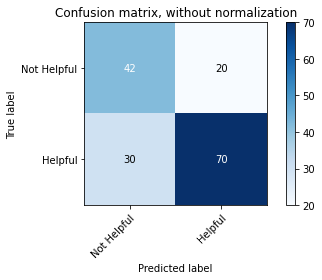

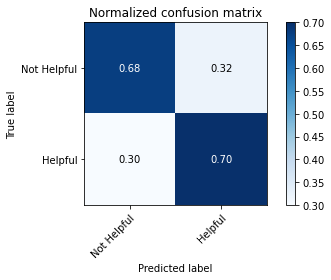

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
%matplotlib inline

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_dash, classes=['Not Helpful','Helpful'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_dash, classes=['Not Helpful','Helpful'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()